In [1]:
# https://medium.com/@romannempyre/sentiment-analysis-using-1d-convolutional-neural-networks-part-1-f8b6316489a2 
from zipfile import ZipFile 
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from pandas import DataFrame

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

from tensorflow.keras.models import Sequential
#from keras import layers

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
  
"""# specifying the zip file name 
file_name = "C:/Users/seeho/datasets/aclImdb/aclImdb.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') """

'# specifying the zip file name \nfile_name = "C:/Users/seeho/datasets/aclImdb/aclImdb.zip"\n  \n# opening the zip file in READ mode \nwith ZipFile(file_name, \'r\') as zip: \n    # printing all the contents of the zip file \n    zip.printdir() \n  \n    # extracting all the files \n    print(\'Extracting all the files now...\') \n    zip.extractall() \n    print(\'Done!\') '

In [2]:
tf.__version__

'2.1.0'

In [4]:
train_dir = 'C:/Users/seeho/datasets/aclImdb/aclImdb/train'

labels = list()
texts = list()

# Processing the labels of the raw IMDB data
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8") # try that
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [5]:
len(texts)

25000

In [6]:
import numpy as np

# cut off reviews after 500 words
max_len = 500 
# train on 10000 samples
training_samples = 10000
 # validate on 10000 samples 
validation_samples = 10000
# consider only the top 10000 words
max_words = 10000 

# import tokenizer with the consideration for only the top 500 words
tokenizer = Tokenizer(num_words=max_words) 
# fit the tokenizer on the texts
tokenizer.fit_on_texts(texts) 
# convert the texts to sequences
sequences = tokenizer.texts_to_sequences(texts) 

word_index = tokenizer.word_index
print('Found %s unique tokens. ' % len(word_index))

 # pad the sequence to the required length to ensure uniformity
data = pad_sequences(sequences, maxlen=max_len)
print('Data Shape: {}'.format(data.shape))

labels = np.asarray(labels)
print("Shape of data tensor: ", data.shape)
print("Shape of label tensor: ", labels.shape)

# split the data into training and validation set but before that shuffle it first
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

# test_data
x_test = data[training_samples+validation_samples:]
y_test = labels[training_samples+validation_samples:]

Found 88582 unique tokens. 
Data Shape: (25000, 500)
Shape of data tensor:  (25000, 500)
Shape of label tensor:  (25000,)


In [7]:
labels[0:10]

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [9]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

callback_list = [
    keras.callbacks.EarlyStopping(
        patience=1,
        monitor='acc',
    ),

    keras.callbacks.ModelCheckpoint(
        monitor='val_loss',
        save_best_only=True,
        filepath='model/',
    ),

    keras.callbacks.ReduceLROnPlateau(
        patience=1,
        factor=0.1,
    )
]

In [10]:
#from keras.layers import Embedding,Conv1D,MaxPooling1D
#from keras.models import Sequential

# model developing
#text_input_layer = keras.Input(shape=(500,))
#embedding_layer = layers.Embedding(max_words, 50)(text_input_layer)


In [11]:
from tensorflow.keras.layers import Embedding,Conv1D,MaxPooling1D,GlobalMaxPooling1D,Dense
#from tf.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
# model developing
text_input_layer = keras.Input(shape=(500,))
embedding_layer = layers.Embedding(max_words, 50)(text_input_layer)
text_layer = Conv1D(256, 3, activation='relu')(embedding_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = Conv1D(256, 3, activation='relu')(text_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = Conv1D(256, 3, activation='relu')(text_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = Conv1D(256, 3, activation='relu')(text_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = Conv1D(256, 3, activation='relu')(text_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = GlobalMaxPooling1D()(text_layer)
text_layer = Dense(256, activation='relu')(text_layer)
output_layer = Dense(1, activation='sigmoid')(text_layer)
model = keras.Model(text_input_layer, output_layer)
model.summary()
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 50)           500000    
_________________________________________________________________
conv1d (Conv1D)              (None, 498, 256)          38656     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 166, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 164, 256)          196864    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 54, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 52, 256)           196864

In [12]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, callbacks=callback_list,
                    validation_data=(x_val, y_val))

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
 9984/10000 [============================>.] - ETA: 0s - loss: 0.6943 - acc: 0.5056WARNING:tensorflow:From C:\Users\seeho\Anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets
10000/10000 [==============================] - 106s 11ms/sample - loss: 0.6943 - acc: 0.5050 - val_loss: 0.6934 - val_acc: 0.4985
Epoch 2/10
10000/10000 [==============================] - 102s 10ms/sample - loss: 0.6510 - acc: 0.5999 - val_loss: 0.5706 - val_acc: 0.7602
Epoch 3/10
10000/10000 [==============================] - 101s 10ms/sample - loss: 0.4228 - acc: 0.8257 - val_loss: 0.7166 - val_acc: 0.7206
Epoch 4/10
10000/10000 [======

In [ ]:
# model.save('model/best_mode.h5') 

In [13]:
# save the tokenizer
tokenizer_path="tokenizer"
import pickle as pk
with open(os.path.join(tokenizer_path, 'tokenizer_m1.pickle'), 'wb') as handle:
    pk.dump(tokenizer, handle, protocol=pk.HIGHEST_PROTOCOL)

In [14]:
"""Also, during training, we were able to save the best model obtained as “movie_sentiment_m1.h5”
in a directory called model. """
tokenizer_path = 'tokenizer'
model_path = 'model'
model_file = os.path.join(model_path, '')
tokenizer_file = os.path.join(tokenizer_path, 'tokenizer_m1.pickle')
model = tf.keras.models.load_model(model_file)

# load tokenizer
with open(tokenizer_file, 'rb') as handle:
    tokenizer = pk.load(handle)

In [15]:
"""With our model and tokenizer at hand, we will then go ahead and write a simple script to score our text samples
(found in the test_dir folder in github repository).
Although scoring the text samples is pretty straight forward, we would like to write a simple script which will
enable us accept text content as a simple string data, a list of strings, a file containing the text to be scored,
and a directory containing a number of text files with texts to be scored in them."""

def review_rating(score, decoded_review):
    if float(score) >= 0.9:
        print('Review: {}\nSentiment: Strongly Positive\nScore: {}'.format(decoded_review, score))
    elif float(score) >= 0.7 and float(score) < 0.9:
        print('Review: {}\nSentiment: Positive\nScore: {}'.format(decoded_review, score))
    elif float(score) >= 0.5 and float(score) < 0.7:
        print('Review: {}\nSentiment: Okay\nScore: {}'.format(decoded_review, score))
    else:
        print('Review: {}\nSentiment: Negative\nScore: {}'.format(decoded_review, score))
    print('\n\n')

In [16]:
def decode_review(text_list):
    word_index = tokenizer.word_index
    sequences = tokenizer.texts_to_sequences(text_list)
    data = pad_sequences(sequences, maxlen=500)

    # decode the words
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    decoded_review = ' '.join([reverse_word_index.get(i, '?') for i in sequences[0]])
    return decoded_review, data

In [17]:
"""Finally, we add the last method which will accept the data in various formats. 
This method will take the source of the text and the type of file (if its a file or a directory of files) as arguments.
We then process them according to the source. """

def score_review(source=None, file_type=None):
    '''
    source: the text, as either a string or a list of strings
    file_type: (str): indicating whether we expecting a file containing the
    text data or a directory containing a list files holding the text
    options: 'file' or 'dir'
    '''
    
    reviewScores=[]
    text_list = list()
    if isinstance(source, str) and file_type is None:
        text_list.append(source)
        decoded_review, data = decode_review(text_list)
        # make prediction
        score = model.predict(data)[0][0]
        review_rating(score, decoded_review)
        reviewScores.append(score)
        
    if isinstance(source, list) and file_type is None:
        for item in source:
            text_list = list()
            text_list.append(item)
            decoded_review, data = decode_review(text_list)
            score = model.predict(data)[0][0]
            review_rating(score, decoded_review)
            reviewScores.append(score)
        
    
    if isinstance(source, str) and file_type == 'file':
        file_data = open(source).read()
        text_list.append(file_data)
        decoded_review, data = decode_review(text_list)
        # make prediction
        score = model.predict(data)[0][0]
        review_rating(score, decoded_review)
        reviewScores.append(score)
        
    
    if isinstance(source, str) and file_type == 'dir':
        file_content_holder = list()
        for fname in os.listdir(source):
            if fname[-4:] == '.txt':
                f = open(os.path.join(source, fname))
                file_content_holder.append(f.read())
                f.close()
        for item in file_content_holder:
            text_list = list()
            text_list.append(item)
            decoded_review, data = decode_review(text_list)
            score = model.predict(data)[0][0]
            review_rating(score, decoded_review)
            reviewScores.append(score)
        
            
    return reviewScores       
            

In [18]:
"""We can then go ahead and test the score review method by using sample data available in the test_dir
repository using the following code:"""

score=score_review('test/', file_type='dir')


Review: i went and saw this movie last night after being to by a few friends of mine i'll admit that i was reluctant to see it because from what i knew of he was only able to do comedy i was wrong played the character of jake very well and kevin played ben randall with such the sign of a good movie is that it can toy with our emotions this one did exactly that the entire theater which was sold out was overcome by awesome laughter during the first half of the movie and were moved to tears during the second half while great and the theater i not only saw many women in tears but many full grown men as well trying desperately not to let anyone see them crying this movie was great and i suggest that you go see it before you judge
Sentiment: Strongly Positive
Score: 0.9921481013298035



Review: market is negative and i hate it bad service and horrible movie
Sentiment: Okay
Score: 0.5825798511505127



Review: years ago when darling played on tv it was always the pan and version which i hate

Review: i was pleasantly surprised to find this movie showing as a sneak preview in my local theater br br we have all seen this plot line before top gun jane an officer and a gentleman but a good script still works this story is basically about the training of a coast guard rescue team with a couple of side story lines kevin plays a highly successful rescue team leader ben randall who is forced into heading the training team after a tough mission the movie takes us through the of the training process and the personal stories of both the character and that of jake played by i am happy to say that is great in this part br br there are no great surprises in this movie and you will probably realize what is coming long before it arrives however the use of humor the exploration of the of the training and the fun of watching ben randall do his own thing as a kept me and thoroughly entertained i really enjoy watching a movie that makes the entire audience laugh out loud gasp here and there an

Review: bloody birthday opens to a shot of general hospital there three babies are being born at precisely the same time during a total a informs us that it is now california june 1 two teenage lovers duke benson ben and annie smith hope are getting down to business in an open grave they hear noises and duke both duke and annie are murdered sheriff jim bert kramer is baffled and only has the handle of a child's skipping rope that annie was holding as a clue unfortunately before sheriff can solve the case his youngest daughter debbie elizabeth and two of her friends curtis taylor billy as billy and steven andy freeman murder him just as they are finishing sheriff off another young boy from their class named timmy k c turns up the three killers are unaware of how much he saw soon after the incident timmy plays with steven and curtis in a curtis locks timmy into an old locker timmy manages to escape and tell his sister but she doesn't believe him at first the three children carry on their

Review: bloody birthday is a totally rubbish slasher movie from beginning to end br br i found the acting to be pretty good considering the genre of movie and its obvious low budget i don't know what was going on with the cinematography but it looked ghastly way too over maybe this is a bad transfer to dvd or maybe it always looked like that i don't know br br there really are no redeeming qualities to speak of there are a few deaths but not really gory i wouldn't bother with it if i was you the best thing about the dvd was the 15 minute interview with producer max who was very amusing and honest he didn't have anything good to say about director ed hunt and admits the movie was a failure but he would like to re make it as he believes it has a decent plot however he died in 2004 so i guess it will be up to someone else to take on that challenge with the way things have been going in the last few years it wouldn't surprise me there's at least one re make per week at the cinema these day

Score: 0.1354832947254181



Review: i wish i knew what to make of a movie like this it seems to be divided into two parts action sequences and personal dramas it follows through survival school guided by master chief kevin then to where a couple of spectacular take place the last resulting in death br br i must say that the scenes on the beach struck me as so stereotypical in so many ways that they should be a typical bar room fight between navy guys and coast pirates the experienced old who is as an elderly bar tender tells him married to the coast guard the older chief who keeps trying to prove to himself that he's still the neglected ex wife to whom pays a farewell visit the seemingly sadistic demands placed on the by the all in pursuit of a goal the gifted young man by a troubled past br br the problem is that we've seen it all before if it's kevin here it's clint eastwood or john wayne or lou jr or or robert deniro elsewhere and the climactic scene has elements drawn shamelessly 

In [19]:
score

[0.9921481,
 0.58257985,
 0.20175222,
 0.88790417,
 0.6707107,
 0.7579041,
 0.38898638,
 0.99373615,
 0.9598654,
 0.9875038,
 0.26748633,
 0.998923,
 0.987573,
 0.017722314,
 0.027608642,
 0.5496763,
 0.18479525,
 0.58257985,
 0.028857987,
 0.9780085,
 0.015877524,
 0.99239963,
 0.9927677,
 0.9222063,
 0.1268727,
 0.99944645,
 0.011997902,
 0.99488634,
 0.02585928,
 0.13718234,
 0.037102725,
 0.90748066,
 0.41974512,
 0.20296115,
 0.77939767,
 0.1354833,
 0.9933252,
 0.8268114,
 0.9728075,
 0.9863268,
 0.014993635,
 0.57964426,
 0.6862459,
 0.3276119,
 0.65765005,
 0.9450084]

[0.9921481, 0.58257985, 0.20175222, 0.88790417, 0.6707107, 0.7579041, 0.38898638, 0.99373615, 0.9598654, 0.9875038, 0.26748633, 0.998923, 0.987573, 0.017722314, 0.027608642, 0.5496763, 0.18479525, 0.58257985, 0.028857987, 0.9780085, 0.015877524, 0.99239963, 0.9927677, 0.9222063, 0.1268727, 0.99944645, 0.011997902, 0.99488634, 0.02585928, 0.13718234, 0.037102725, 0.90748066, 0.41974512, 0.20296115, 0.77939767, 0.1354833, 0.9933252, 0.8268114, 0.9728075, 0.9863268, 0.014993635, 0.57964426, 0.6862459, 0.3276119, 0.65765005, 0.9450084]


<BarContainer object of 46 artists>

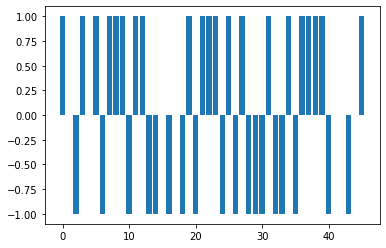

In [20]:
def ScorePosNegGet(score):
    retScore=None
    if float(score) >= 0.7:
        #print('Review: {}\nSentiment: Strongly Positive\nScore: {}'.format(decoded_review, score))
        retScore=1.
    elif float(score)>=0.5 and float(score)<0.7:
        #print('Review: {}\nSentiment: Okay\nScore: {}'.format(decoded_review, score))
        retScore=0.
    else:
        retScore=-1.
        #print('Review: {}\nSentiment: Negative\nScore: {}'.format(decoded_review, score))
    #print('\n\n')
    return retScore

print(score)

y=scoresPosNeg=[ScorePosNegGet(i) for i in score]
x=posPosNeg=[i for i in range(len(score))]
aa=list(enumerate(scoresPosNeg))

plt.bar(x,y)

Positive: 28 negative: 18


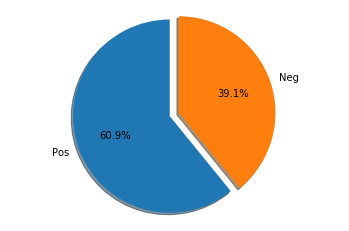

In [21]:
import matplotlib.pyplot as plt
p_s=0
n_s=0

for i in score:
    if float(i) > 0.51:
        p_s = p_s + 1
        
    elif float(i) <= 0.51:
        n_s = n_s + 1
    else:
        print("error reading")


print("Positive: {} negative: {}" .format(p_s, n_s))

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Pos', 'Neg'
#sizes = [15, 30, 45, 10]
#sizes = [15, 85]
sizes = [p_s, n_s]

explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Neg')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()